In [1]:
from ipfml.processing import segmentation, transform
from ipfml import utils
from ipfml import metrics
from PIL import Image
from scipy import signal
from skimage import color
import scipy.stats as stats
import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import math

In [2]:
# update matplotlip params
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels

In [3]:
data_folder = "../../../thesis-data/fichiersSVD_light/"

# SVD analysis on zones of Synthesis Images 

## Utils functions definition

In [4]:
def compute_images_path(dict_data):
    scene = dict_data['name']
    prefix = dict_data['prefix']
    indices = dict_data['indices']
    
    images_path = []
    for index in indices:
        
        index_str = str(index)
        
        while len(index_str) < 5:
            index_str = "0" + index_str
            
        path = os.path.join(data_folder, os.path.join(scene, prefix + index_str + ".png"))
        images_path.append(path)
    return images_path

In [5]:
def get_images_zones(dict_data, images_path):
    
    zones_indices = dict_data['zones']
    zones_img = []
    
    for indice in zones_indices:
        
        zones_list = []
        
        for path in images_path:
            img = Image.open(path)
            zones = segmentation.divide_in_blocks(img, (200, 200))

            zones_list.append(zones[indice])
            
        zones_img.append(zones_list)
        
    return zones_img

In [6]:
def display_sv_entropy_zones(dict_data, zones_entropy_list, _norm=False):
    
    scene_name = dict_data['name']
    image_indices = dict_data['indices']
    zones_indices = dict_data['zones']
    zones_thresholds = dict_data['thresholds']
    colors = ['C0', 'C1']
    
    plt.figure(figsize=(25, 20))
    
    sv_data = []
    begin, end = interval
    
    # before plotting something, need to get min and max y value
    min_v = 100000000
    max_v = 0
    
    for id_zone, zone in enumerate(zones_indices):
    
        data = zones_entropy_list[id_zone]
        
        if _norm:
            data = utils.normalize_arr(data)
            
        if min_v > min(data):
            min_v = min(data)
            
        if max_v < max(data):
            max_v = max(data)
        
    
    for id_zone, zone in enumerate(zones_indices):
    
        data = zones_entropy_list[id_zone]
        
        if _norm:
            data = utils.normalize_arr(data)
                
        plt.plot(data, 
                 color=colors[id_zone], 
                 label='Zone ' + str(zones_indices[id_zone]) + ' of ' + scene_name)
        
        i = 0
        while image_indices[i] < zones_thresholds[id_zone]: 
            i = i + 1
        
        threshold_found = image_indices[i]
        
        plt.plot([i, i], [max_v, 0], 'k-', lw=2, color=colors[id_zone])

    x_labels = [str(label) for label in image_indices if int(label) % 50 == 0]
    
    x = [i for i, v in enumerate(image_indices) if int(v) % 50 == 0 ]
    
    plt.xticks(x, x_labels, rotation=45)
    plt.legend(fontsize=18)
    plt.show()

In [7]:
def display_sv_diff_entropy_zones(dict_data, zones_diff_list, _norm=False):
    
    scene_name = dict_data['name']
    # remove first element from image_indices because first element is used for computing first diff value
    image_indices = dict_data['indices'][1:]
    zones_indices = dict_data['zones']
    zones_thresholds = dict_data['thresholds']
    colors = ['C0', 'C1']
    
    plt.figure(figsize=(25, 20))
    
    sv_data = []
    begin, end = interval
    
    # before plotting something, need to get min and max y value
    min_v = 100000000
    max_v = 0
    
    for id_zone, zone in enumerate(zones_indices):
    
        data = zones_diff_list[id_zone]
        
        if _norm:
            data = utils.normalize_arr(data)
            
        if min_v > min(data):
            min_v = min(data)
            
        if max_v < max(data):
            max_v = max(data)
    
    for id_zone, zone in enumerate(zones_indices):
    
        data = zones_diff_list[id_zone]
        
        if _norm:
            data = utils.normalize_arr(data)
                
        plt.plot(data, 
                 color=colors[id_zone], 
                 label='Zone ' + str(zones_indices[id_zone]) + ' of ' + scene_name)
        
        i = 0
        while image_indices[i] < zones_thresholds[id_zone]: 
            i = i + 1
        
        threshold_found = image_indices[i]
        
        plt.plot([i, i], [max_v, 0], 'k-', lw=2, color=colors[id_zone])

    x_labels = [str(label) for label in image_indices if int(label) % 50 == 0]
    
    x = [i for i, v in enumerate(image_indices) if int(v) % 50 == 0 ]
    
    plt.xticks(x, x_labels, rotation=45)
    plt.legend(fontsize=18)
    plt.show()

In [8]:
def get_zone_entropy(images):
    
    entropy_list = []
    
    for img in images:
        s_entropy = utils.get_entropy(transform.get_LAB_L_SVD_s(img))
        entropy_list.append(s_entropy)
        
    return entropy_list

In [9]:
def get_zone_diff_entropy(entropy_list):
    
    diff_list = []
    previous_value = 0
    
    for index, value in enumerate(entropy_list):
        
        if index == 0:
            previous_value = value
        else:
            diff = previous_value - value
            diff_list.append(diff)
            previous_value = value
        
    return diff_list

In [10]:
# Useful function

def get_highest_values(arr, n):
    return np.array(arr).argsort()[-n:][::-1]

def get_lowest_values(arr, n):
    return np.array(arr).argsort()[::-1][-n:][::-1]

## Scenes zones data

In [11]:
# start 00020 - ref 00900 - step 10
dict_appart = {'name': 'Appart1opt02', 
               'prefix': 'appartAopt_', 
               'indices': np.arange(20, 910, 10),
               'zones': [3, 6],
               'thresholds': [280, 310]
              } # use of zone 3 and 6 of flat scene

# start 00050 - ref 01200 - step 10
dict_cuisine = {'name': 'Cuisine01', 
               'prefix': 'cuisine01_', 
               'indices': np.arange(50, 1210, 10),
               'zones': [3, 6],
               'thresholds': [390, 350]
               }

# start 00020 - ref 00950 - step 10
dict_sdb_c = {'name': 'SdbCentre', 
               'prefix': 'SdB2_', 
               'indices': np.arange(20, 960, 10),
               'zones': [3, 6]}

# start 00020 - ref 00950 - step 10
dict_sdb_d = {'name': 'SdbDroite', 
               'prefix': 'SdB2_D_', 
               'indices': np.arange(20, 960, 10),
               'zones': [2, 3, 10, 13]}

## Utilisation de la scène appartement pour aperçu des tendances de l'entropy des SV

In [12]:
current_dict = dict_appart
interval = (0, 200)

In [13]:
images_path = compute_images_path(current_dict)
zones_data = get_images_zones(current_dict, images_path)

### Affichage des zones utilisées pour la scène appartement

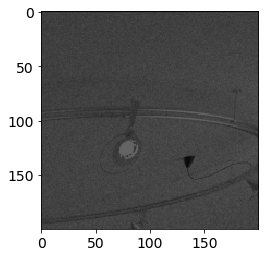

In [14]:
first_image = zones_data[0][0]
first_image = transform.get_LAB_L(first_image)

first_image = Image.fromarray(first_image).convert('L')
plt.imshow(first_image)

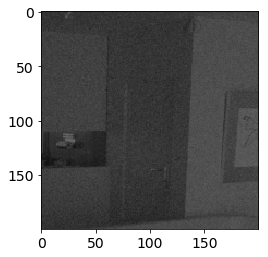

In [15]:
second_image = zones_data[1][0]
second_image = transform.get_LAB_L(second_image)

second_image = Image.fromarray(second_image).convert('L')
plt.imshow(second_image)

### Etude des valeurs d'entropies par zones sur la scène Appartement

In [16]:
zones_entropy_list = []
for zone in zones_data:
    l = get_zone_entropy(zone)
    zones_entropy_list.append(l)

#### Affichage des valeurs d'entropies sur les SV sur les zones 3 et 6 de la scène Appartement (non normalisées)

Les lignes verticales représentent le seuil de la zone en question

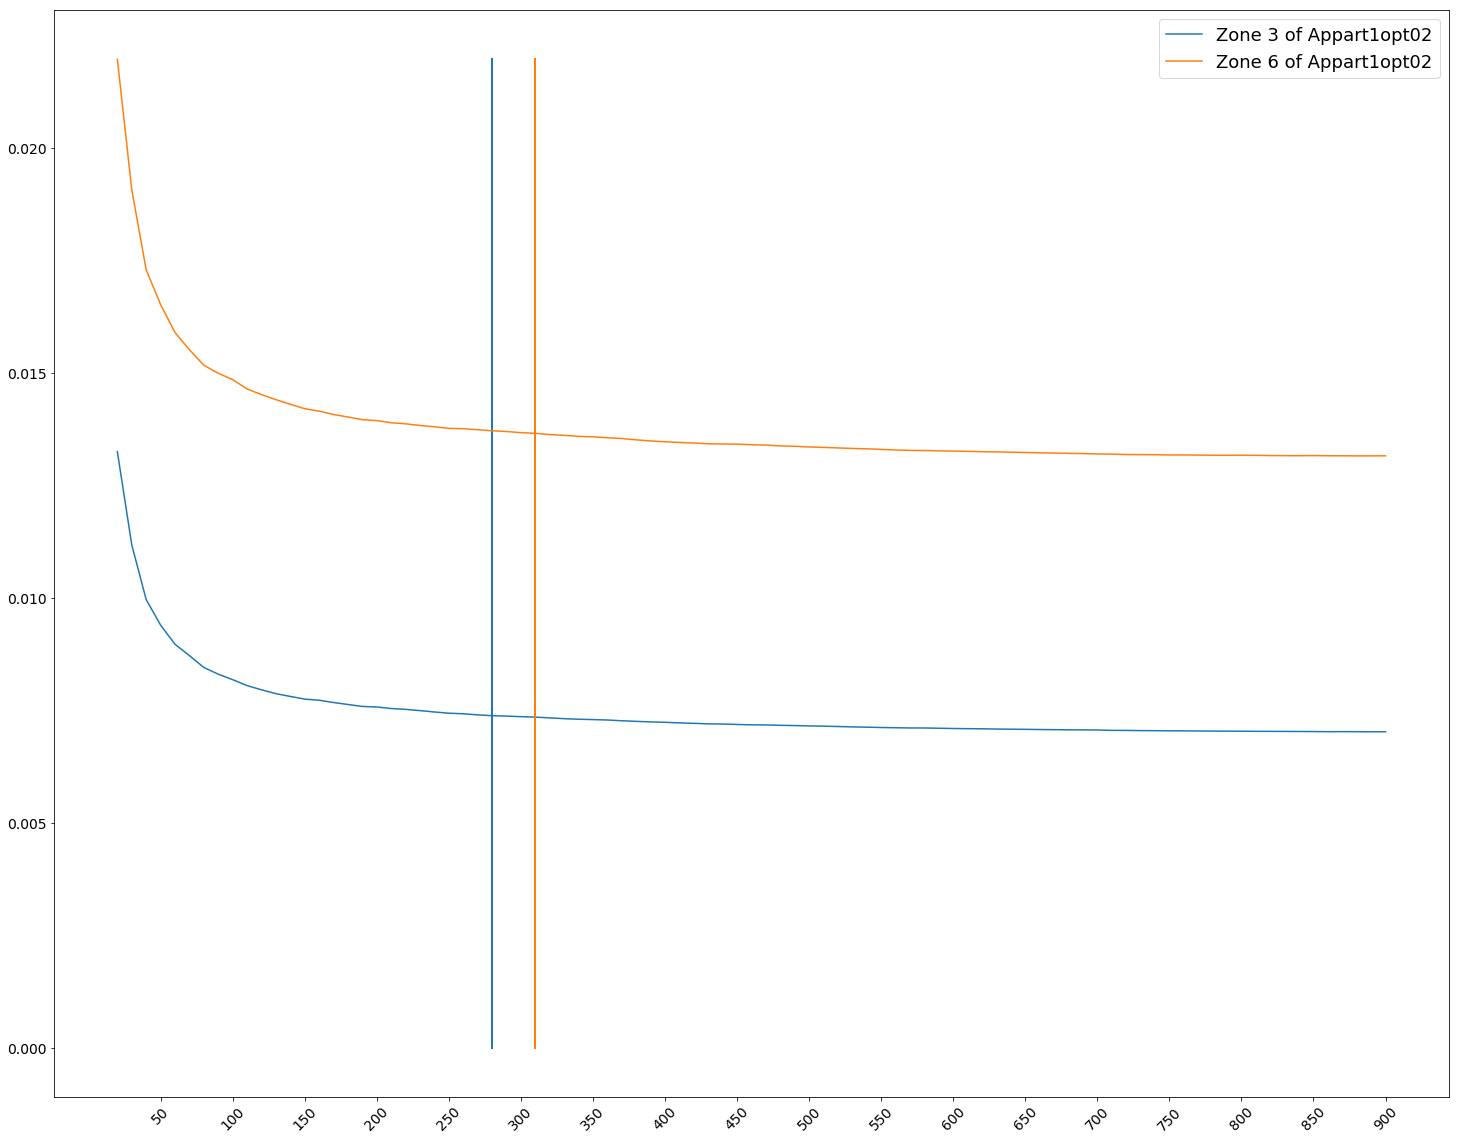

In [17]:
display_sv_entropy_zones(current_dict, zones_entropy_list)

### Affichage des valeurs d'entropies sur les SV sur les zones 3 et 6 de la scène Appartement (ici normalisées)

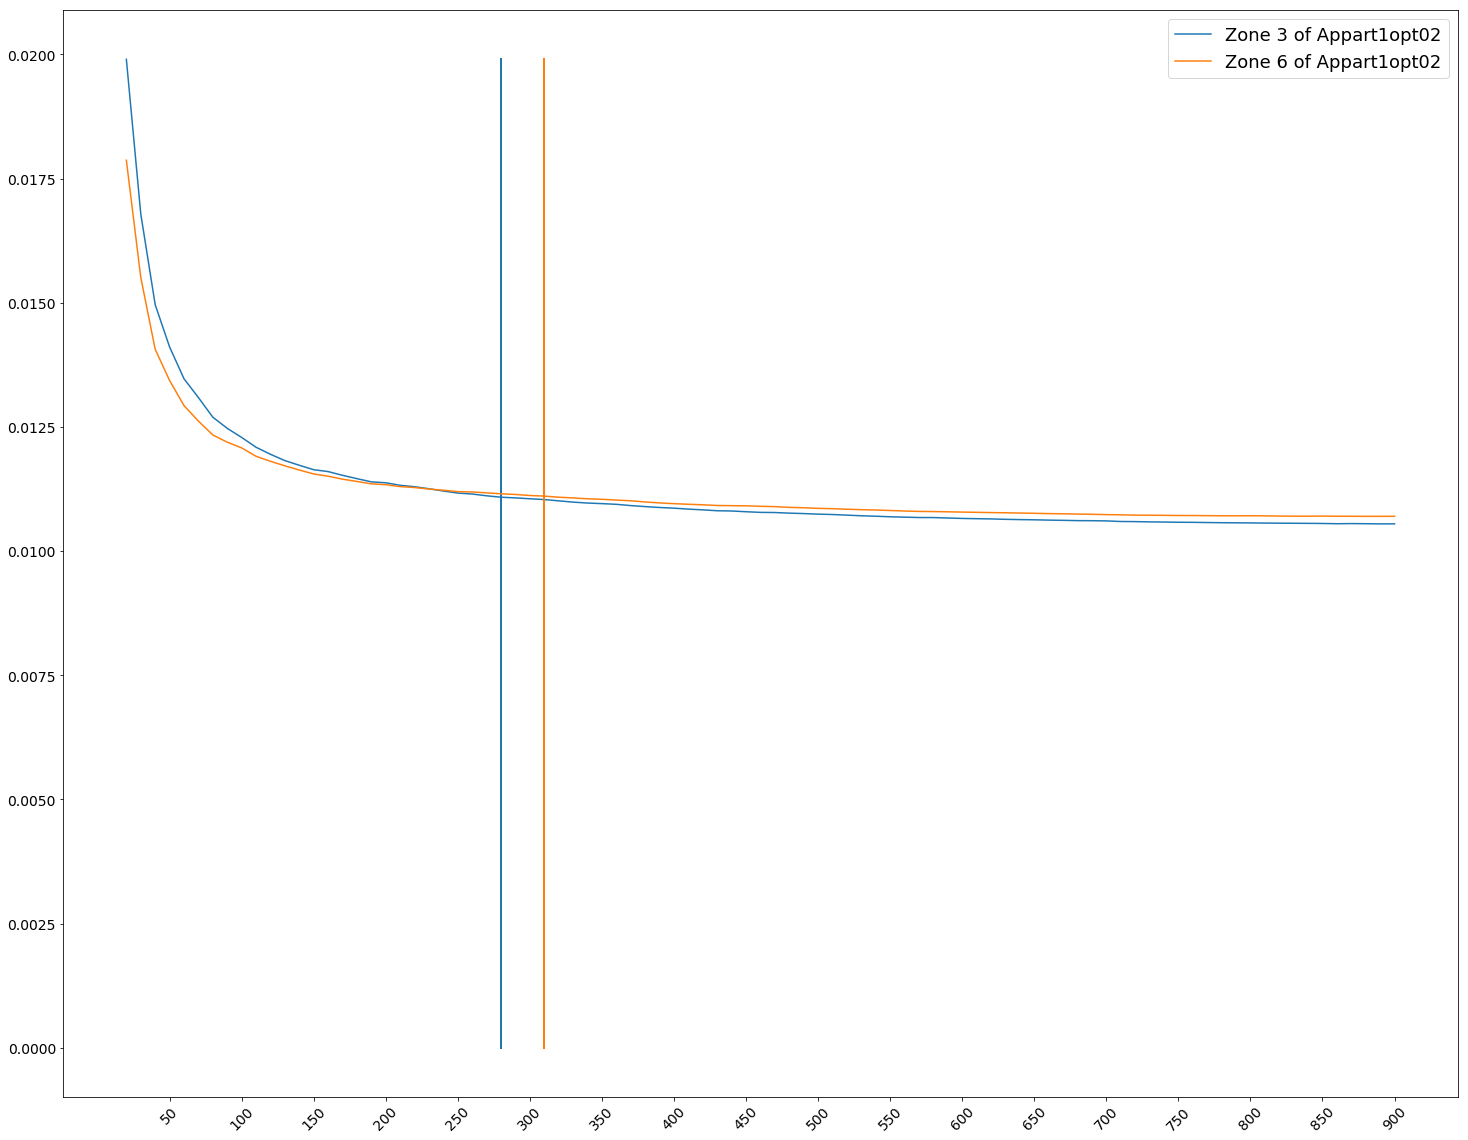

In [18]:
display_sv_entropy_zones(current_dict, zones_entropy_list, True)

In [32]:
zones_diff_entropy_list = []
for zone in zones_data:
    entropy_list = get_zone_entropy(zone)
    diff_list = get_zone_diff_entropy(entropy_list)
    zones_diff_entropy_list.append(diff_list)

### Affichage des différences d'entropies (des SV) au court du rendu sur les zones 3 et 6 de la scène Appartement (non normalisées)

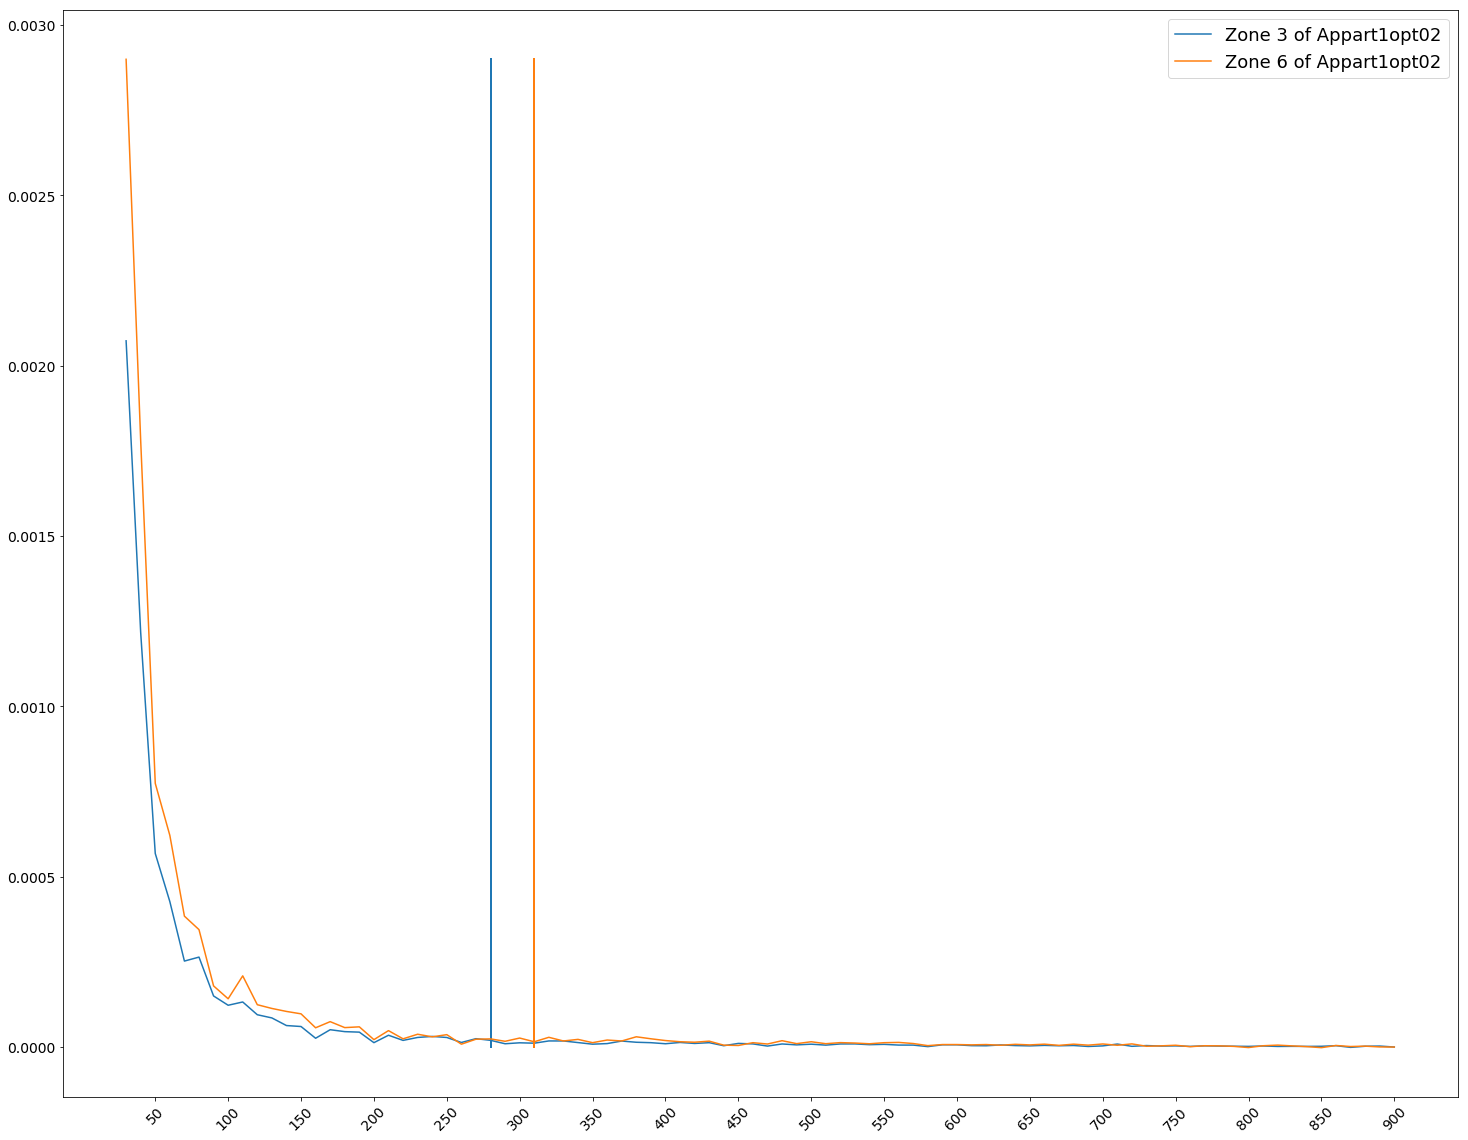

In [20]:
display_sv_diff_entropy_zones(current_dict, zones_diff_entropy_list)

### Affichage des différences d'entropies (des SV) au court du rendu sur les zones 3 et 6 de la scène Appartement (ici normalisées)

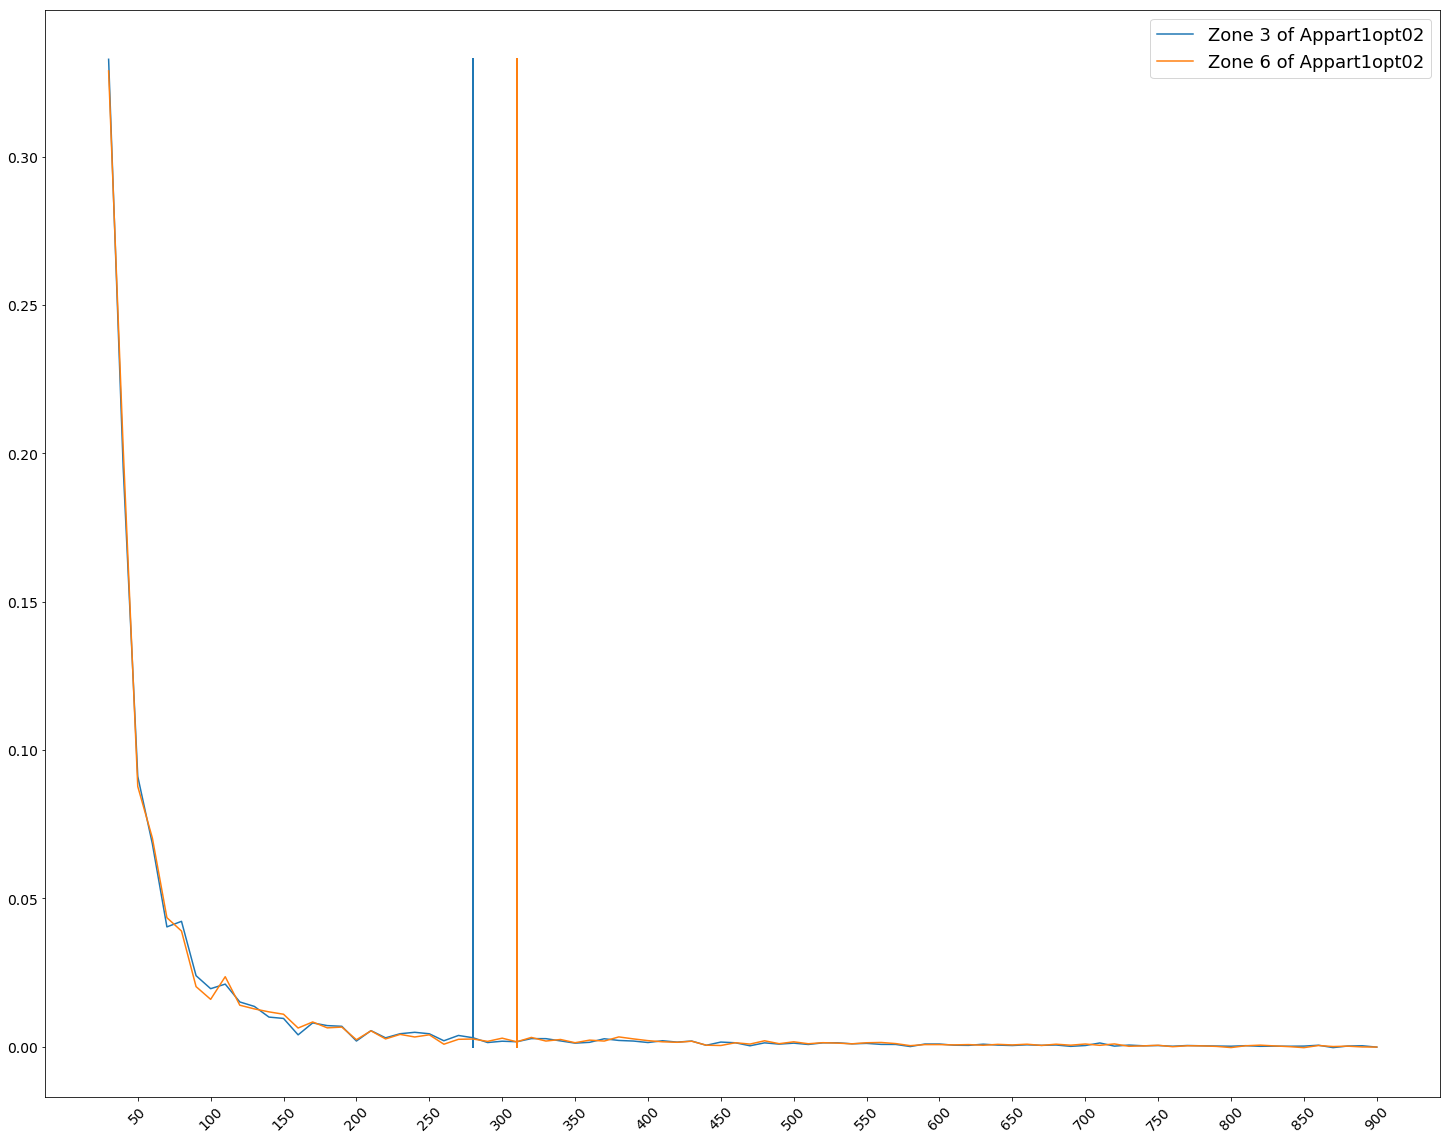

In [21]:
display_sv_diff_entropy_zones(current_dict, zones_diff_entropy_list, True)

## Utilisation de la scène Cuisine pour aperçu des tendances de l'entropy des SV

In [22]:
current_dict = dict_cuisine
interval = (0, 200)

In [23]:
images_path = compute_images_path(current_dict)
zones_data = get_images_zones(current_dict, images_path)

### Affichage des zones utilisées pour la scène cuisine

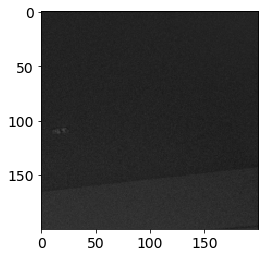

In [24]:
first_image = zones_data[0][0]
first_image = transform.get_LAB_L(first_image)

first_image = Image.fromarray(first_image).convert('L')
plt.imshow(first_image)

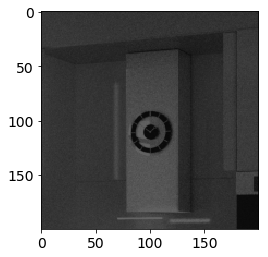

In [25]:
second_image = zones_data[1][0]
second_image = transform.get_LAB_L(second_image)

second_image = Image.fromarray(second_image).convert('L')
plt.imshow(second_image)

In [26]:
zones_entropy_list = []
for zone in zones_data:
    l = get_zone_entropy(zone)
    zones_entropy_list.append(l)

### Etude des valeurs d'entropies par zones sur la scène Cuisine

#### Affichage des valeurs d'entropies sur les SV sur les zones 3 et 6 de la scène Cuisine (non normalisées)

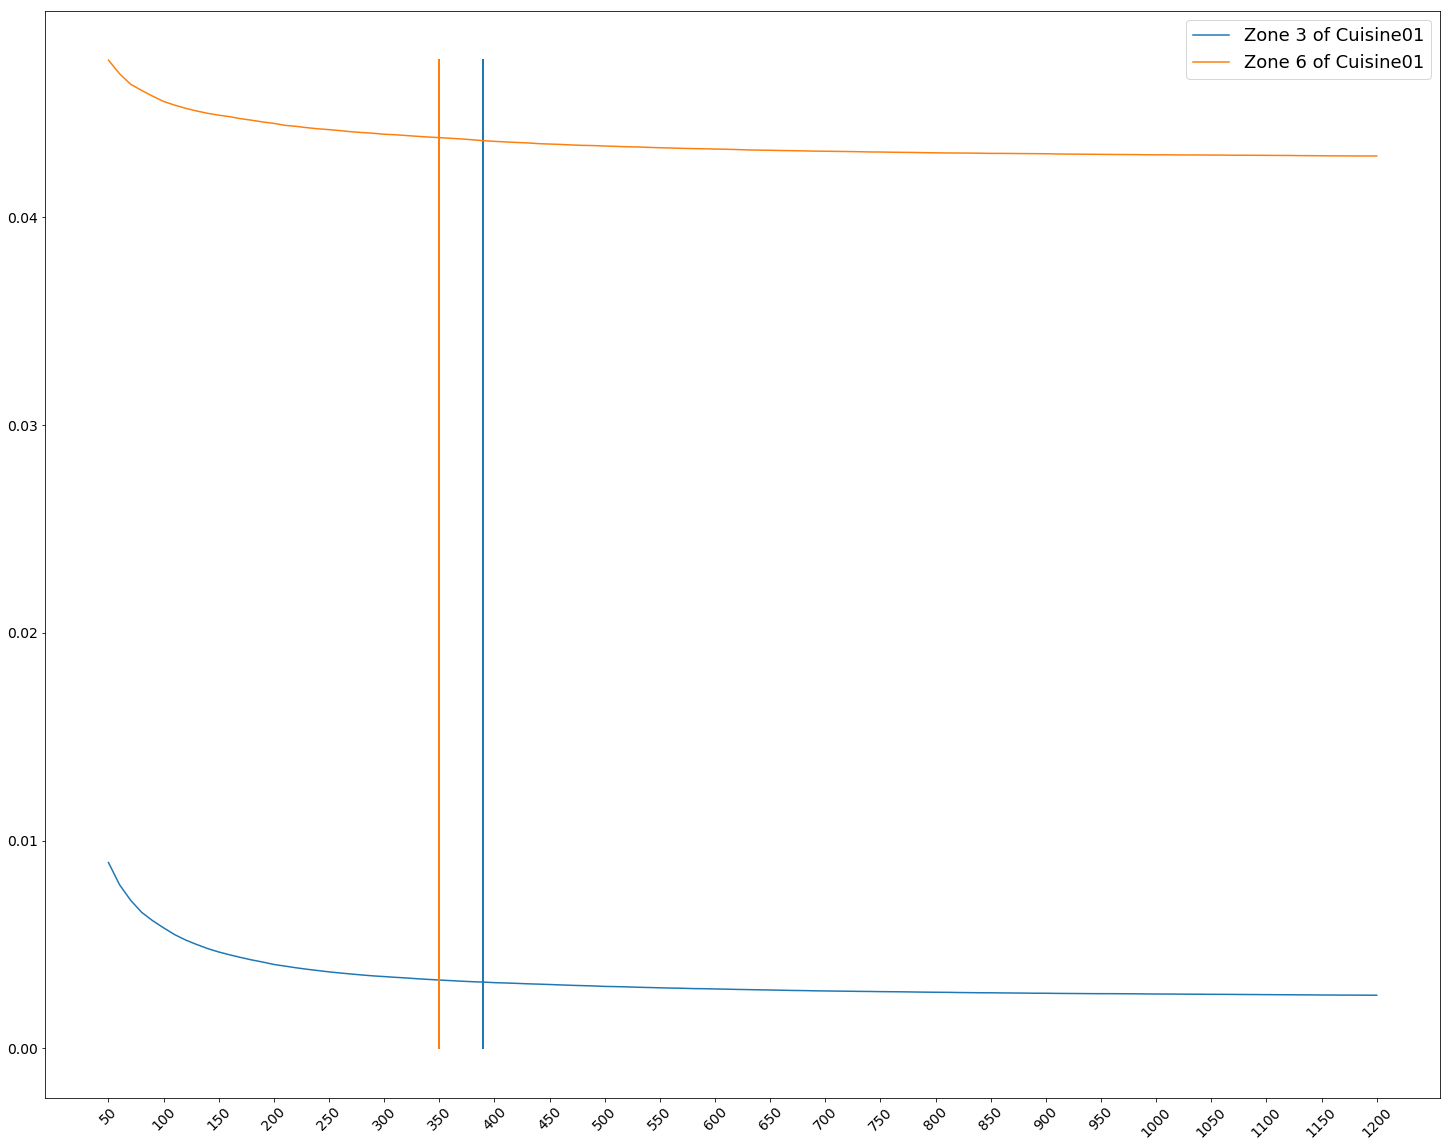

In [27]:
display_sv_entropy_zones(current_dict, zones_entropy_list)

#### Affichage des valeurs d'entropies sur les SV sur les zones 3 et 6 de la scène Cuisine (ici normalisées)

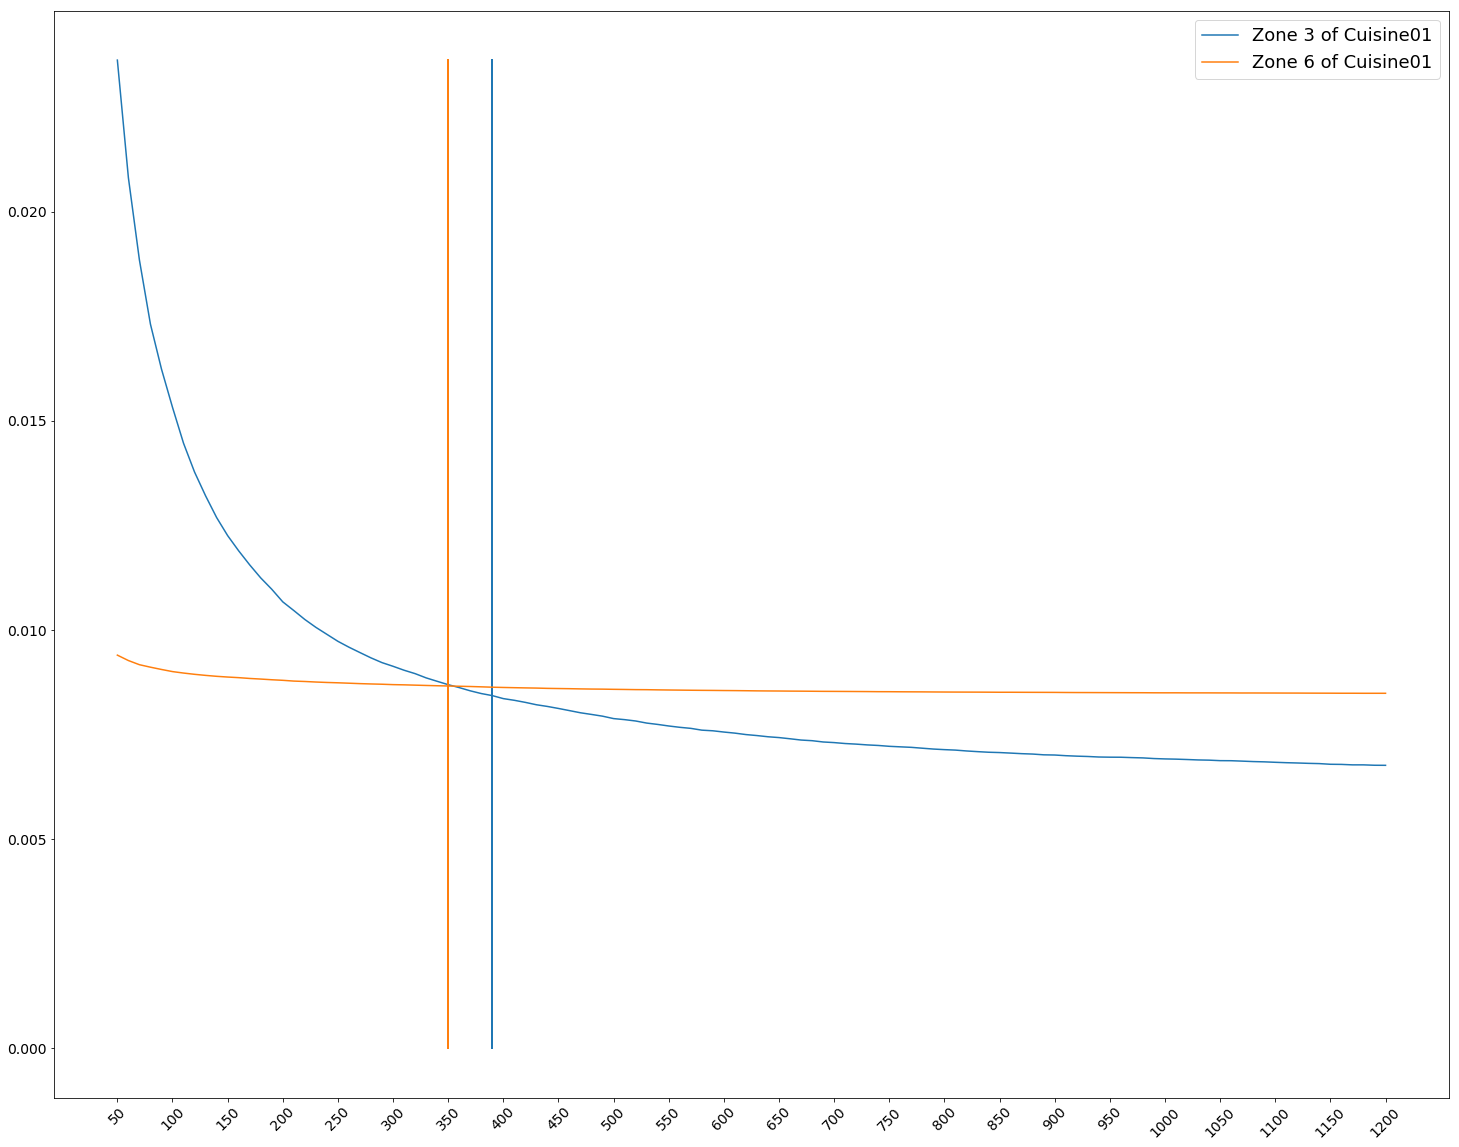

In [28]:
display_sv_entropy_zones(current_dict, zones_entropy_list, True)

### Etude des valeurs d'entropies par zones sur la scène Cuisine

In [29]:
zones_diff_entropy_list = []
for zone in zones_data:
    entropy_list = get_zone_entropy(zone)
    diff_list = get_zone_diff_entropy(entropy_list)
    zones_diff_entropy_list.append(diff_list)

#### Affichage des différences d'entropies (des SV) au court du rendu sur les zones 3 et 6 de la scène Cuisine (non normalisées)

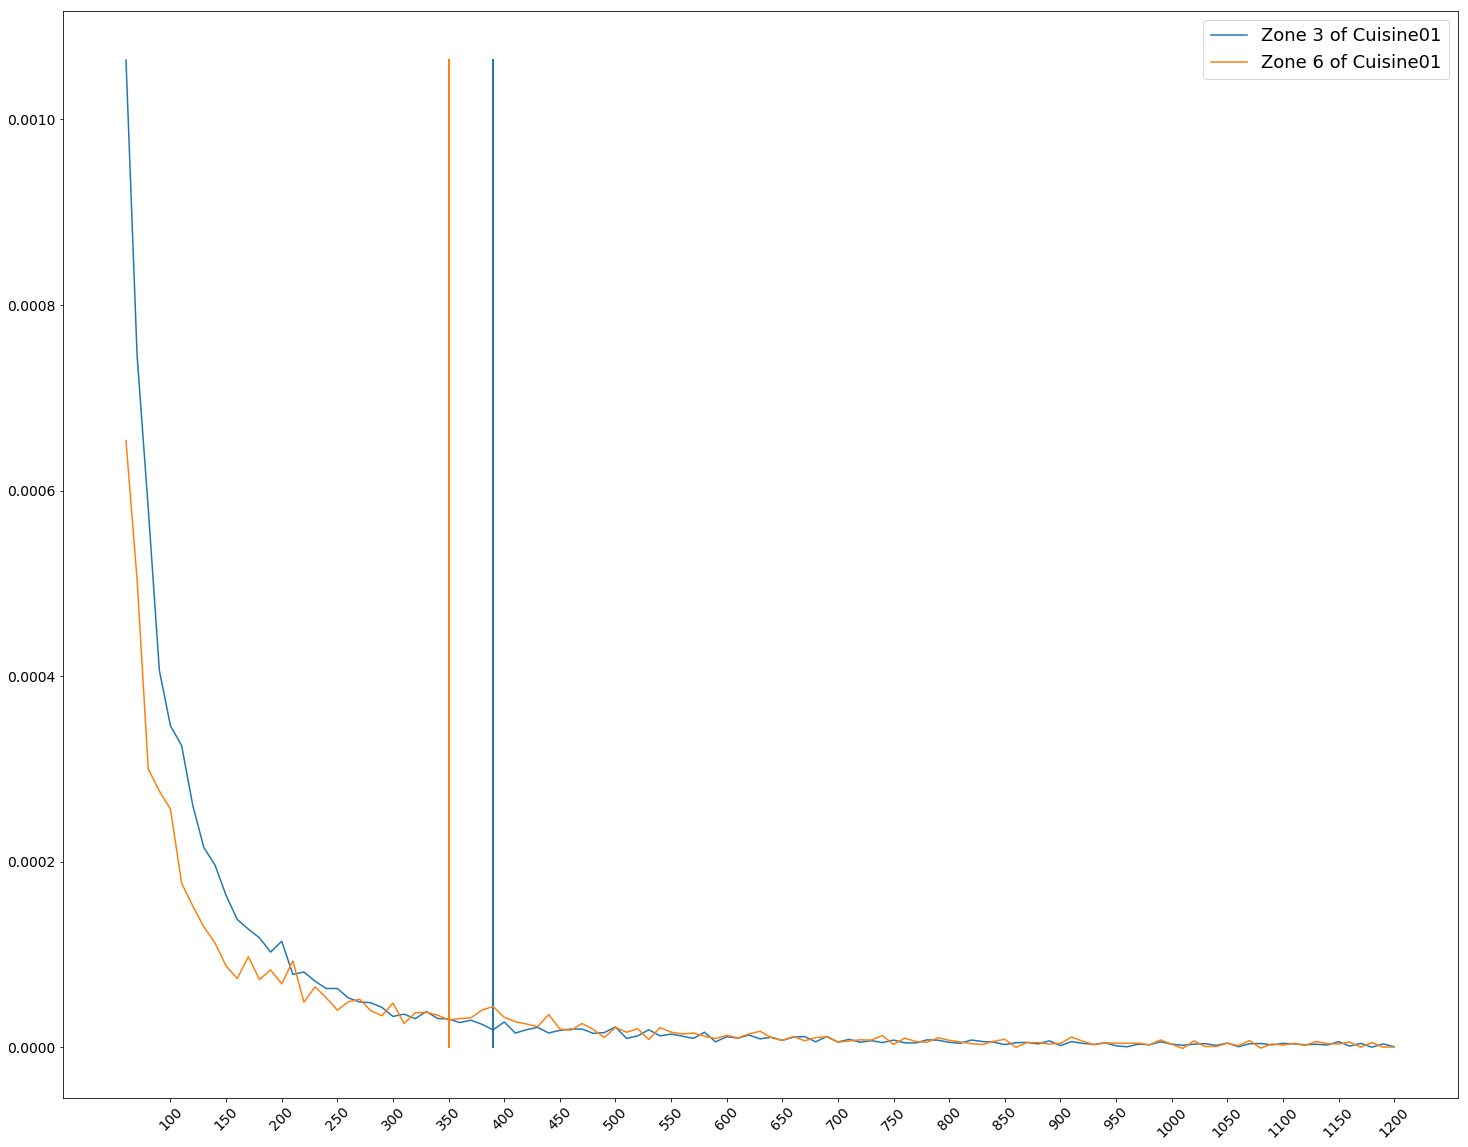

In [30]:
display_sv_diff_entropy_zones(current_dict, zones_diff_entropy_list)

#### Affichage des différences d'entropies (des SV) au court du rendu sur les zones 3 et 6 de la scène Cuisine (ici normalisées)

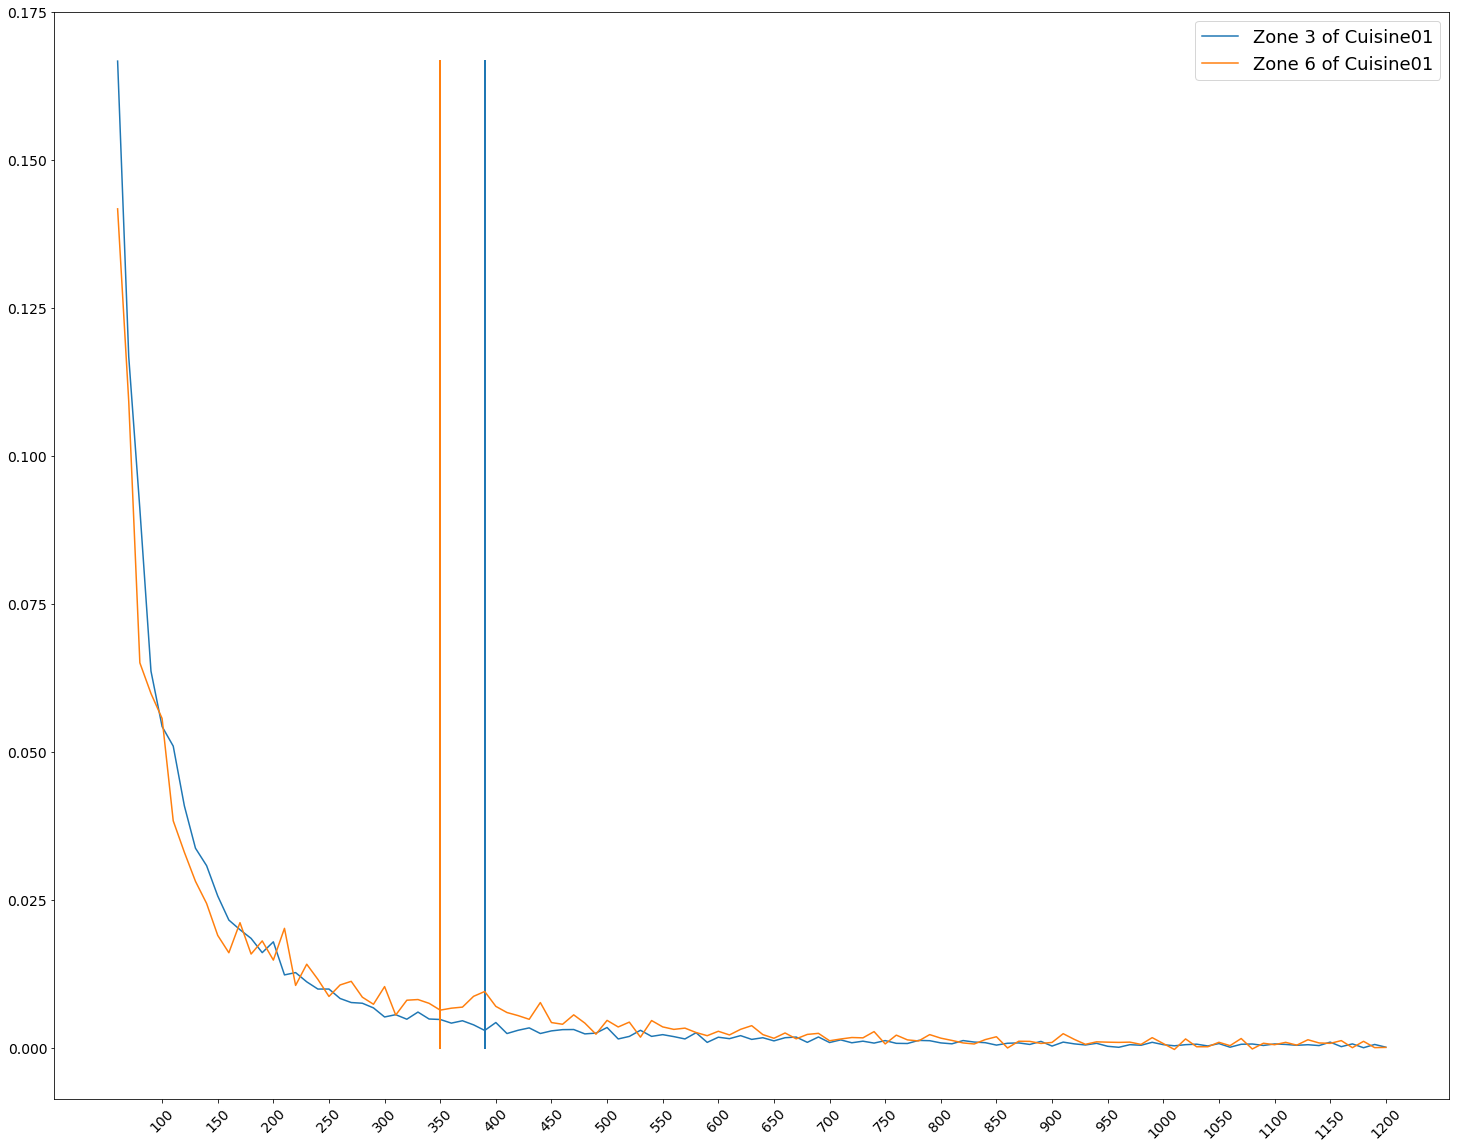

In [31]:
display_sv_diff_entropy_zones(current_dict, zones_diff_entropy_list, True)